In [1]:
import tensorflow as tf
import glob
import scipy.io.wavfile as wavfile
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from preproc import *
%matplotlib inline

In [2]:
global SMP_RATE
SMP_RATE = 16000

In [3]:
def getWaveName(wavepath):
    return wavepath.split('/')[-1]

def findWave(wavefile,path):
    r = glob.glob(path+wavefile)
    return r[0]

In [4]:
# fpath = '../../cmu_artic/female_us_slt/' #desktop
# mpath = '../../cmu_artic/male_us_bdl/' #desktop
fpath = '../data/female_us/'
mpath = '../data/male_us/'

# Hacky parallel dataset

In [5]:
# map male to female
m2f = dict()
for i in glob.glob(mpath+'/*.wav'):
    m2f[i]=findWave(getWaveName(i),fpath)

In [6]:
m2f.keys()[0]

'../data/male_us/arctic_a0058.wav'

# Bin before hand

In [7]:
bin_size_x = (2,3)
bin_size_y = (2,3)

In [8]:
bin_mapping = {}
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    size = wav_data.shape[0]/(1.0*fm)
    if size < bin_size_x[1] and size > bin_size_x[0]:
        fm2, wav_data2 = wavfile.read(m2f[filename])
        size2 = wav_data2.shape[0]/(1.0*fm2)
        if size2 < bin_size_x[1] and size2 > bin_size_x[0]:
            bin_mapping[filename] = m2f[filename]

In [9]:
len(bin_mapping)

348

# Padding

In [10]:
def padTo(x,size,kind='SYM'):
    """
    Expects 1D array
    """
    assert kind in ['LEFT','RIGHT','SYM']
    if kind == 'LEFT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((pad,x),axis=0)
    elif kind == 'RIGHT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((x,pad),axis=0)
    elif kind == 'SYM':
        padl = np.zeros((size-len(x))/2,dtype=x.dtype)
        padr = np.zeros((size-len(x))/2+(size-len(x))%2,dtype=x.dtype)
        r = np.concatenate((padl,x,padr),axis=0)
    return r

# Batch Generator

convolution expects data of shape (batchsize,height,width,inchannel)

Data should be of shape (batchsize,height=1,time_length (this is width),inchannel=1)

In [17]:
#note spec width was hacked so it truncated the data so it is divisible by 2
class Batch(object):
    def __init__(self,mapping,bin_max,batch_size=1):
        self.mapping = mapping
        self.bin_max = bin_max
        self.batch_size = batch_size
        self.seq_size = self.bin_max*SMP_RATE # raw audio
        self.spec_width = self.seq_size/get_seg_size()*get_overlap()+1
        self.spec_height = get_seg_size()/2+1
        self.shape = (self.batch_size,self.spec_height,self.spec_width-1,1)
        self.x_list = mapping.keys()
        self.size = len(self.x_list) #data size
        self.cursors = [(self.size//self.batch_size)*i for i in range(self.batch_size)]
        
    def getBatch(self):
        #get the file names
        x_path = [self.x_list[c] for c in self.cursors]
        y_path = [self.mapping[xp] for xp in x_path]
        
        #Get the x,y files and pad
        x = np.empty(shape=self.shape)
        y = np.empty(shape=self.shape)
        for i,(xp,yp) in enumerate(zip(x_path,y_path)):
            _,x_raw=wavfile.read(xp)
            _,y_raw=wavfile.read(yp)
            x_pad = padTo(x_raw,self.bin_max*SMP_RATE)
            y_pad = padTo(y_raw,self.bin_max*SMP_RATE)
            x[i,:,:,0]=compute_spectrogram(x_pad)[:,:self.spec_width-1]
            y[i,:,:,0]=compute_spectrogram(y_pad)[:,:self.spec_width-1]
            
        #update cursor positions
        self.cursors = [(c+1)%self.size for c in self.cursors]
        return (x,y)

# PReLU

In [18]:
def prelu(x,name='prelu'):
    in_shape = x.get_shape().as_list()
    with tf.variable_scope(name):
        alpha = tf.get_variable('alpha',in_shape[-1],
                               initializer=tf.constant_initializer(0.1),
                               dtype=tf.float32)
        pos = tf.nn.relu(x)
        neg = alpha * (x-tf.abs(x))*.5
        
        return pos + neg

# Set up Batch

In [19]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=32)

# Build Graph and give inputs

In [20]:
g = tf.Graph()
with g.as_default():
    #try None shapes
    x = tf.placeholder(tf.float32,shape=b.shape)
    y = tf.placeholder(tf.float32,shape=b.shape)

# Generator

In [22]:
fw = 31 #filter width

with g.as_default():    
    #down convolutions operations
    with tf.variable_scope('in'):
        with tf.variable_scope('l1'):
            # Shape (height,width,inchannels,out_channels)
            conv1=tf.get_variable('conv1',shape=[1,fw,1,1],initializer=tf.truncated_normal_initializer(0,.01))
            b1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.01))
            l1=prelu(tf.nn.conv2d(x,conv1,strides=[1,1,2,1],padding='SAME')+b1)
        with tf.variable_scope('l2'):
            conv2=tf.get_variable('conv2',shape=[1,fw,1,16],initializer=tf.truncated_normal_initializer(0,.01))
            b2 = tf.get_variable('b2',shape=16,initializer=tf.constant_initializer(0.01))
            l2=prelu(tf.nn.conv2d(l1,conv2,strides=[1,1,2,1],padding='SAME')+b2)
#         with tf.variable_scope('l3'):
#             conv3=tf.get_variable('conv3',shape=[1,fw,16,32],initializer=tf.truncated_normal_initializer(0,.01))
#             b3 = tf.get_variable('b3',shape=32,initializer=tf.constant_initializer(0.01))
#             l3=prelu(tf.nn.conv2d(l2,conv3,strides=[1,1,2,1],padding='SAME')+b3)
#         with tf.variable_scope('l4'):
#             conv4=tf.get_variable('conv4',shape=[1,fw,32,32],initializer=tf.truncated_normal_initializer(0,.01))
#             b4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.01))
#             l4=prelu(tf.nn.conv2d(l3,conv4,strides=[1,1,2,1],padding='SAME')+b4)
#         with tf.variable_scope('l5'):
#             conv5=tf.get_variable('conv5',shape=[1,fw,32,64],initializer=tf.truncated_normal_initializer(0,.01))
#             b5 = tf.get_variable('b5',shape=64,initializer=tf.constant_initializer(0.01))
#             l5=prelu(tf.nn.conv2d(l4,conv5,strides=[1,1,2,1],padding='SAME')+b5)
        
    last_shape = l2.get_shape()
    es=int(last_shape[2]) #encoding size
    
    # Transpose Convolution
    #Create variables
    with tf.variable_scope('out'):
#         with tf.variable_scope('dl5'):
#             # Shape (height,width,out_channels,input channels)
#             dconv5 = tf.get_variable('dconv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.01))
#             db5 = tf.get_variable('b5',shape=32,initializer=tf.constant_initializer(0.01))
#             dl5 = prelu(tf.nn.conv2d_transpose(l5,dconv5,output_shape=[b.batch_size,b.spec_height,(2**1)*es,32],strides=[1,1,2,1])+db5)
#         with tf.variable_scope('dl4'):
#             dconv4 = tf.get_variable('dconv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.01))
#             db4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.01))
#             dl4 = prelu(tf.nn.conv2d_transpose(dl5,dconv4,output_shape=[b.batch_size,b.spec_height,(2**2)*es,32],strides=[1,1,2,1])+db4)
#         with tf.variable_scope('dl3'):
#             dconv3 = tf.get_variable('dconv3',shape=[1,fw,16,32],initializer=tf.truncated_normal_initializer(0,.01))
#             db3 = tf.get_variable('b3',shape=16,initializer=tf.constant_initializer(0.01))
#             dl3 = prelu(tf.nn.conv2d_transpose(l3,dconv3,output_shape=[b.batch_size,b.spec_height,(2**1)*es,16],strides=[1,1,2,1])+db3)
        with tf.variable_scope('dl2'):
            dconv2 = tf.get_variable('dconv2',shape=[1,fw,1,16],initializer=tf.truncated_normal_initializer(0,.01))
            db2 = tf.get_variable('b2',shape=1,initializer=tf.constant_initializer(0.01))
            dl2 = prelu(tf.nn.conv2d_transpose(l2,dconv2,output_shape=[b.batch_size,b.spec_height,(2**1)*es,1],strides=[1,1,2,1])+db2)
        with tf.variable_scope('dl1'):
            dconv1 = tf.get_variable('dconv1',shape=[1,fw,1,1],initializer=tf.truncated_normal_initializer(0,.01))
            db1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.01))
            dl1 = prelu(tf.nn.conv2d_transpose(dl2,dconv1,output_shape=b.shape,strides=[1,1,2,1],padding='SAME')+db1)
            
    #loss function
    loss = tf.reduce_mean(tf.square(dl1 - y))
    
    #optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=.0002)
    
    #original optimization
    opt = optimizer.minimize(loss)
    init=tf.global_variables_initializer()
    
    saver = tf.train.Saver()

In [23]:
sess = tf.Session(graph=g)
sess.run(init)

In [33]:
# test if forward passes work
x_data,y_data = b.getBatch()
fd = {x:x_data,y:y_data}
_ = sess.run(dl1,feed_dict=fd)

In [25]:
losses = []

In [26]:
save_path = 'modelckpt/supervised_spec.ckpt'
#saver.restore(save_path)

In [40]:
save_step = 500
num_steps=1000
for i in tqdm(xrange(num_steps)):
    x_data,y_data = b.getBatch()
    fd = {x:x_data,y:y_data}
    _,l = sess.run([opt,loss],feed_dict=fd)
    losses.append(l)
    if i % save_step == 0:
        save_path = saver.save(sess, save_path)

100%|██████████| 1000/1000 [18:33<00:00,  1.09s/it]


In [41]:
dl2.get_shape()

TensorShape([Dimension(32), Dimension(161), Dimension(150), Dimension(1)])

# Evaluate Data

In [42]:
with g.as_default():
    gen_audio = dl1

In [43]:
x_data,y_data = b.getBatch() #uncomment if not training
fd = {x:x_data,y:y_data} #uncomment if not training
result = sess.run(gen_audio,feed_dict=fd)

In [44]:
x_org = compute_inverse_spectrogram(x_data[0,:,:,0])
gener = compute_inverse_spectrogram(result[0,:,:,0])
y_tar = compute_inverse_spectrogram(y_data[0,:,:,0])

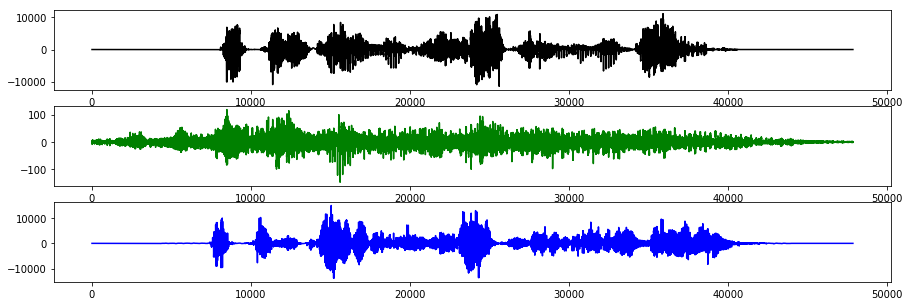

In [45]:
plt.figure(figsize=(15,5))
plt.subplot(311)
plt.plot(x_org,color='black')
plt.subplot(312)
plt.plot(gener,color='green')
plt.subplot(313)
plt.plot(y_tar,color='blue')

In [34]:
for i in g.get_collection('trainable_variables'):
    print i.name

in/l1/conv1:0
in/l1/b1:0
in/l1/prelu/alpha:0
in/l2/conv2:0
in/l2/b2:0
in/l2/prelu/alpha:0
out/dl2/dconv2:0
out/dl2/b2:0
out/dl2/prelu/alpha:0
out/dl1/dconv1:0
out/dl1/b1:0
out/dl1/prelu/alpha:0


# Write to audio file

In [38]:
#generated
f = open('samples/generated_audio1.wav','wr')
wavfile.write(f,SMP_RATE,gener.astype(np.int16))
f.close()

In [39]:
#original
f = open('samples/org_audio1.wav','wr')
wavfile.write(f,SMP_RATE,x_org.astype(np.int16))
f.close()

In [45]:
#target
f = open('samples/target_audio1.wav','wr')
wavfile.write(f,SMP_RATE,y_tar.astype(np.int16))
f.close()